In [1]:
import sys
# sys.path.append("../exp009")
# from train_stage1 import RSNA2024Stage1LightningModel, RSNA2024Stage1Dataset, RSNA2024Stage1DataModule, EXP_ID
import pandas as pd
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display
from glob import glob
import cv2
from tqdm.auto import tqdm
import pydicom
import h5py

In [2]:
train_descriptions = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
train_coord_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
train_coord_df = train_coord_df.merge(train_descriptions, on=["series_id", "study_id"], how="left")
train_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")


train_descriptions = pd.read_csv(
    "../../input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv"
)
train_coord_df = pd.read_csv(
    "../../input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv"
)
train_coord_df = train_coord_df.merge(
    train_descriptions, on=["series_id", "study_id"], how="left"
)
train_df = pd.read_csv(
    "../../input/rsna-2024-lumbar-spine-degenerative-classification/train.csv"
)
train_df["fold_id"] = -1
for i, (train_index, valid_index) in enumerate(
    GroupKFold(n_splits=5).split(
        train_df, np.arange(len(train_df)), train_df.study_id
    )
):
    train_df.loc[valid_index, "fold_id"] = i
train_coord_df = train_coord_df.merge(
    train_df.loc[:, ["study_id", "fold_id"]], on=["study_id"], how="left"
)
train_coord_df = train_coord_df.sort_values(
    by=["study_id", "series_id", "level", "condition"]
).reset_index(drop=True)
coord_label_num = (
    train_coord_df.groupby("series_id")
    .count()
    .sort_values("series_id")
    .study_id.to_numpy()
)
SCS = (
    train_coord_df.groupby("series_id")
    .head(1)
    .sort_values("series_id")
    .condition.to_numpy()
)
series_id = (
    train_coord_df.groupby("series_id").head(1).sort_values("series_id").series_id
)
new_series_id = series_id[
    ((SCS == "Spinal Canal Stenosis") & (coord_label_num == 5))
    | ((SCS != "Spinal Canal Stenosis") & (coord_label_num == 10))
]
new_train_coord_df = (
    train_coord_df[train_coord_df.series_id.isin(new_series_id)]
    .sort_values(by=["series_id", "level"])
    .reset_index(drop=True)
)
wrong_series_ids = [
    221289021,
    1735851779,
    880361156,
    1921917205,
    2231471633,
    737753815,
    1488857550,
    3736941525,
    1490272456,
    3086719329,
    1485193299,
    3521409198,
    816381378,
]

new_train_coord_df =  new_train_coord_df[~new_train_coord_df.series_id.isin(wrong_series_ids)]
# new_train_coord_df = new_train_coord_df[
#     new_train_coord_df.series_description
#     == series_description.replace("_", " ").replace("-", "/")
# ].reset_index()


In [54]:
series_description = "Sagittal T1"
# series_description = "Sagittal T2/STIR"
series_id = new_train_coord_df[new_train_coord_df.series_description == series_description].series_id.unique()[101]
series_df = new_train_coord_df[new_train_coord_df.series_id == series_id].sort_values(["level", "condition"])
dicoms = [pydicom.dcmread(glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_id}/{i}.dcm")[0]) for i in series_df.instance_number]
print(dicoms[0].Rows, dicoms[0].Columns)
orig_x = np.asarray([dicom.Columns for dicom in dicoms])
orig_y = np.asarray([dicom.Rows for dicom in dicoms])
series_df.loc[:, "x"] = series_df.loc[:, "x"] / orig_x
series_df.loc[:, "y"] = series_df.loc[:, "y"] / orig_y
if len(series_df) == 10:
    new_series_df = series_df.iloc[::2].reset_index(drop=True)
    new_series_df = new_series_df.astype(
        {"instance_number": np.float32, "x": np.float32, "y": np.float32}
    )
    new_series_df.loc[:, ["instance_number", "x", "y"]] = (
        series_df.iloc[0::2].loc[:, ["instance_number", "x", "y"]].to_numpy()
        + series_df.iloc[1::2].loc[:, ["instance_number", "x", "y"]].to_numpy()
    ) / 2
    new_series_df = new_series_df.rename(columns={"label":"label_l"})
    new_series_df["label_r"] = series_df.iloc[1::2].reset_index(drop=True).label
else:
    assert len(series_df) == 5
    new_series_df = series_df.reset_index(drop=True)
new_series_df

384 384


/tmp/ipykernel_3274283/1442514595.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.52926347 0.49797483 0.46521896 0.44923079 0.45793987]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  new_series_df.loc[:, ["instance_number", "x", "y"]] = (
/tmp/ipykernel_3274283/1442514595.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.18836489 0.29379987 0.41436899 0.52626627 0.63584228]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  new_series_df.loc[:, ["instance_number", "x", "y"]] = (


,study_id,series_id,instance_number,condition,level,x,y,series_description,fold_id,label_l,label_r
0,2383836357,217610363,9.5,Left Neural Foraminal Narrowing,L1/L2,0.529263,0.188365,Sagittal T1,4,Normal/Mild,Normal/Mild
1,2383836357,217610363,9.5,Left Neural Foraminal Narrowing,L2/L3,0.497975,0.293800,Sagittal T1,4,Normal/Mild,Normal/Mild
2,2383836357,217610363,10.0,Left Neural Foraminal Narrowing,L3/L4,0.465219,0.414369,Sagittal T1,4,Normal/Mild,Normal/Mild
3,2383836357,217610363,10.0,Left Neural Foraminal Narrowing,L4/L5,0.449231,0.526266,Sagittal T1,4,Normal/Mild,Normal/Mild
4,2383836357,217610363,9.5,Left Neural Foraminal Narrowing,L5/S1,0.457940,0.635842,Sagittal T1,4,Normal/Mild,Normal/Mild


In [4]:
idx = 4
def dist(row1, row2):
    return np.sqrt((row1.x - row2.x) ** 2 + (row1.y - row2.y) ** 2)
dists = []
if idx + 1 < len(new_series_df):
    dists.append(dist(new_series_df.iloc[idx], new_series_df.iloc[idx + 1]))
if idx - 1 >= 0:
    dists.append(dist(new_series_df.iloc[idx], new_series_df.iloc[idx - 1]))
d = sum(dists) / len(dists) * 1.2
h5f = h5py.File("../../input/volume_orig_res.h5")
volume = h5f[str(series_df.series_id.iloc[0])]
volume.shape

(18, 384, 384)

In [5]:
crop = volume[:, 
       int((new_series_df.iloc[idx].y - d) * volume.shape[1]): int((new_series_df.iloc[idx].y + d) * volume.shape[1]), 
       int((new_series_df.iloc[idx].x - d) * volume.shape[2]): int((new_series_df.iloc[idx].x + d) * volume.shape[2])
]
# crop = volume[:, 
#        int((new_series_df.iloc[idx].y - d) * volume.shape[1]): int((new_series_df.iloc[idx].y + d) * volume.shape[1]), 
#        int((new_series_df.iloc[idx].x - d * 2) * volume.shape[2]): int((new_series_df.iloc[idx].x) * volume.shape[2])
# ]
crop.shape

(18, 101, 101)

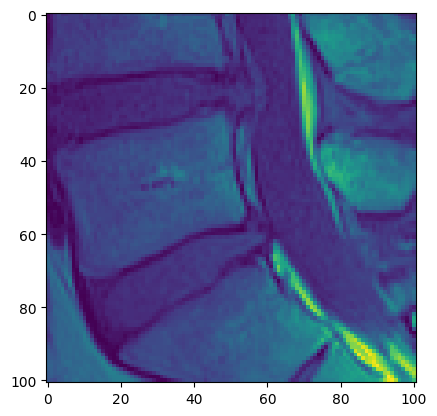

In [6]:
plt.imshow(crop[8])

In [39]:
label = []
for idx in tqdm(range(len(new_train_coord_df))):
    study_id, condition, level = new_train_coord_df.iloc[idx][["study_id", "condition", "level"]]
    cond_target = "_".join(condition.lower().split(" ") + level.lower().split("/"))
    label.append(train_df[train_df.study_id==study_id].loc[:, cond_target].iloc[0])
new_train_coord_df["label"] = label

  0%|          | 0/43870 [00:00<?, ?it/s]

In [40]:
new_train_coord_df

,study_id,series_id,instance_number,condition,level,x,y,series_description,fold_id,label
0,3996069892,10996,13,Left Neural Foraminal Narrowing,L1/L2,266.827697,166.544283,Sagittal T1,0,Normal/Mild
1,3996069892,10996,6,Right Neural Foraminal Narrowing,L1/L2,264.630404,163.686737,Sagittal T1,0,Normal/Mild
2,3996069892,10996,12,Left Neural Foraminal Narrowing,L2/L3,252.811594,205.294686,Sagittal T1,0,Normal/Mild
3,3996069892,10996,6,Right Neural Foraminal Narrowing,L2/L3,258.064459,197.391921,Sagittal T1,0,Normal/Mild
4,3996069892,10996,12,Left Neural Foraminal Narrowing,L3/L4,249.513688,243.220612,Sagittal T1,0,Moderate
...,...,...,...,...,...,...,...,...,...,...
43925,916362094,4294540297,11,Spinal Canal Stenosis,L1/L2,254.122744,159.104693,Sagittal T2/STIR,2,Normal/Mild
43926,916362094,4294540297,10,Spinal Canal Stenosis,L2/L3,239.566787,209.241877,Sagittal T2/STIR,2,Moderate
43927,916362094,4294540297,10,Spinal Canal Stenosis,L3/L4,229.054152,256.144404,Sagittal T2/STIR,2,Moderate
43928,916362094,4294540297,9,Spinal Canal Stenosis,L4/L5,231.480144,300.620939,Sagittal T2/STIR,2,Severe


In [7]:
train_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,fold_id
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,4
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild,1
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,2
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,3
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,3
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,4
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,0
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,3
